# PROJECT 1 - PART 2

## 0 - imports

In [170]:
from pathlib import Path
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
from tabulate import tabulate
from captum.attr import IntegratedGradients
import torch
import random
import os
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adamax
if tf.config.list_physical_devices('GPU'):
    print("Using GPU :)")
else:
    print("No GPU :/")

No GPU :/


## 1 - Q1 Exploratory Data Analysis

### 1.1 - loading data

In [171]:
# 0 - path to train/test/val folders
train = Path("datasets/chest_xray/train")
val = Path("datasets/chest_xray/val")
test = Path("datasets/chest_xray/test")

# 1 - function to create dataframe for train, val, test data
def create_dataframe(directory):
    # path to the normal and pneumonia sub-directories
    normal_cases_dir = directory / 'NORMAL'
    pneumonia_cases_dir = directory / 'PNEUMONIA'

    # list of all the images
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

    data = []

    # set label for normal cases to be 0
    for img in normal_cases:
        data.append((img, 0))

    # set label for pneumonia cases to be 1
    for img in pneumonia_cases:
        data.append((img, 1))

    # shuffle otherwise all 0 and then all 1
    df = pd.DataFrame(data, columns=['image', 'label'])
    df = df.sample(frac=1.).reset_index(drop=True)
    
    return df


train_df = create_dataframe(train)
val_df = create_dataframe(val)
test_df = create_dataframe(test)

print("Train Data:")
print(train_df.head())

print("\nVal Data:")
print(val_df.head())

print("\nTest Data:")
print(test_df.head())

Train Data:
                                               image  label
0  datasets/chest_xray/train/PNEUMONIA/person500_...      1
1  datasets/chest_xray/train/PNEUMONIA/person682_...      1
2  datasets/chest_xray/train/NORMAL/NORMAL2-IM-06...      0
3  datasets/chest_xray/train/PNEUMONIA/person643_...      1
4  datasets/chest_xray/train/NORMAL/NORMAL2-IM-08...      0

Val Data:
                                               image  label
0  datasets/chest_xray/val/NORMAL/NORMAL2-IM-1430...      0
1  datasets/chest_xray/val/PNEUMONIA/person1951_b...      1
2  datasets/chest_xray/val/NORMAL/NORMAL2-IM-1437...      0
3  datasets/chest_xray/val/NORMAL/NORMAL2-IM-1431...      0
4  datasets/chest_xray/val/PNEUMONIA/person1954_b...      1

Test Data:
                                               image  label
0  datasets/chest_xray/test/NORMAL/IM-0001-0001.jpeg      0
1  datasets/chest_xray/test/NORMAL/NORMAL2-IM-002...      0
2  datasets/chest_xray/test/PNEUMONIA/person1634_...      1
3  da

In [172]:
# X and y splits
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

### 1.2 - dataset exploration

In [173]:
# 0 - explore dataset dimension
def get_dataset_info(directory):
    pneumonia_path = os.path.join(directory, 'PNEUMONIA')
    normal_path = os.path.join(directory, 'NORMAL')
    num_pneumonia = len(os.listdir(pneumonia_path))
    num_normal = len(os.listdir(normal_path))
    return num_pneumonia, num_normal

train_pneumonia, train_normal = get_dataset_info(train)
val_pneumonia, val_normal = get_dataset_info(val)
test_pneumonia, test_normal = get_dataset_info(test)

data = [
    ["Train set", train_pneumonia, train_normal],
    ["Validation set", val_pneumonia, val_normal],
    ["Test set", test_pneumonia, test_normal]
]

headers = ["Dataset", "PNEUMONIA", "NORMAL"]

print(tabulate(data, headers=headers, tablefmt="grid"))


+----------------+-------------+----------+
| Dataset        |   PNEUMONIA |   NORMAL |
+================+=============+==========+
| Train set      |        3875 |     1341 |
+----------------+-------------+----------+
| Validation set |           8 |        8 |
+----------------+-------------+----------+
| Test set       |         390 |      234 |
+----------------+-------------+----------+


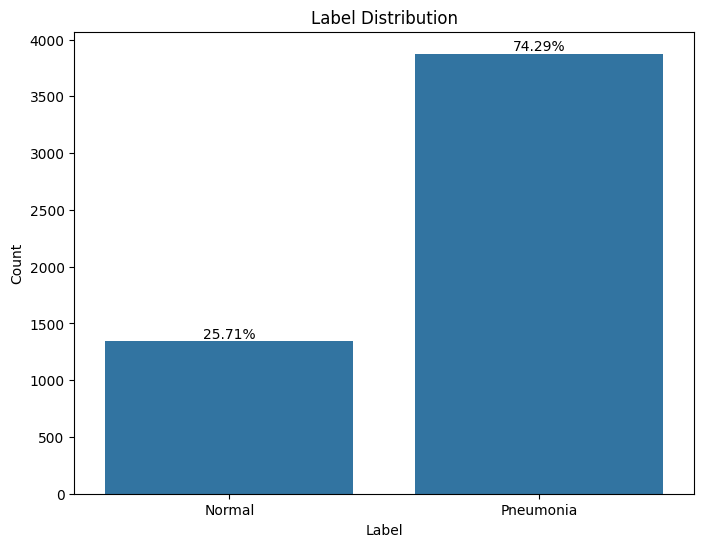

In [174]:
# 1 - label distribution
label_counts = train_df['label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
ax=sb.countplot(x='label', data=train_df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Pneumonia'])
for i,p in enumerate(ax.patches):
        height = p.get_height()
        if height > 0: 
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 30,f'{label_counts[i]:.2f}%',
                    ha="center")
plt.show()

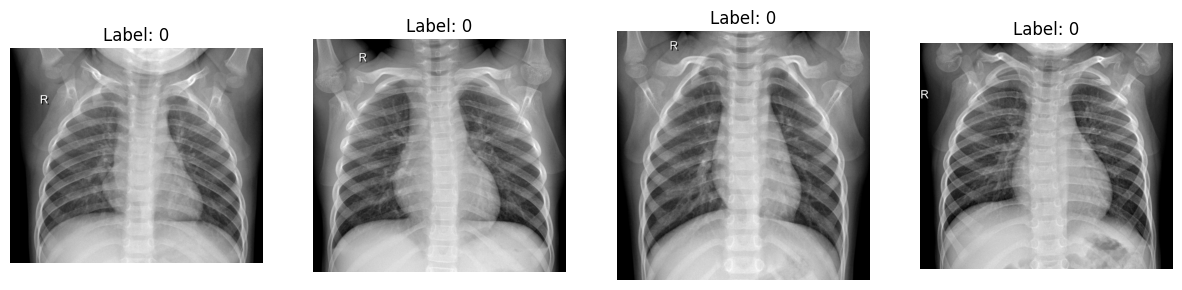

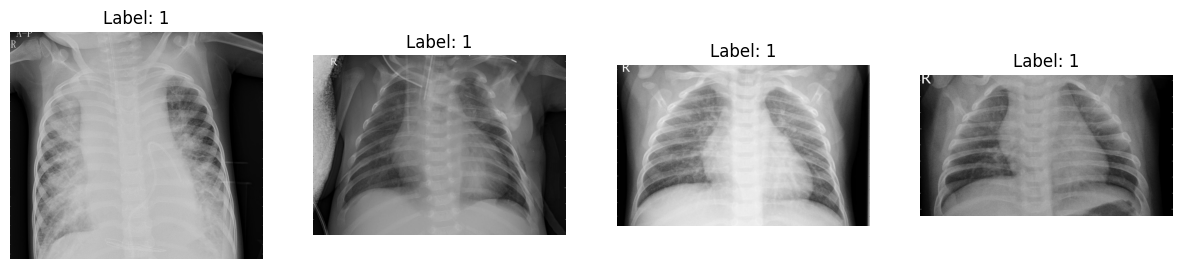

In [175]:
# 3 - plot samples
def plot_examples(df, label, num_examples=4):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    filtered_df = df[df['label'] == label].sample(num_examples)
    for i, (_, row) in enumerate(filtered_df.iterrows()):
        img_path = row['image']
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

plot_examples(train_df, label=0)
plot_examples(train_df, label=1)

#### REPORT:
- I can't see any difference between normal and pneumonia xrays
- data is highly imbalanced. We have almost with thrice pneumonia cases here as compared to the normal cases. To increase the number of training examples, we can use data augmentation


### 1.3 - data preprocessing

In [176]:
classes = np.array(['NORMAL', 'PNEUMONIA'])

TRAIN_RATIO = 0.80  # the rest is validation
base_path = os. getcwd() + '/datasets/chest_xray/'

def img_paths_and_labels__dirname(dirname):
    data = []
    for label in classes:
        subdir_path = os.path.join(base_path, dirname, label)
        for filename in os.listdir(subdir_path):
              data.append({ 'img_path': os.path.join(subdir_path, filename), 'label': label })
    return pd.DataFrame(data)

def img_paths_and_labels__train_val(balance_classes_by_removing_excess_data=True):
    # 1. concat the given train and validation data
    train_df = img_paths_and_labels__dirname('train')
    val_df = img_paths_and_labels__dirname('val')
    unsplit_df = pd.concat([train_df, val_df], ignore_index=True)

    # 2. make sure the new train & val have exactly 50%-50% NORMAL-PNEUMONIA
    def split_rows_of_(label):
        """take the rows that have this label, and split them into 2 (train, val)"""
        df = unsplit_df[unsplit_df['label'] == label]
        train_df, val_df = train_test_split(df, train_size=TRAIN_RATIO)
        return train_df, val_df

    train_0_df, val_0_df = split_rows_of_('NORMAL')
    train_1_df, val_1_df = split_rows_of_('PNEUMONIA')
    
    if balance_classes_by_removing_excess_data:
        len_each_train = min(map(len, [train_0_df, train_1_df]))
        train_0_df = train_0_df.iloc[: len_each_train]
        train_1_df = train_1_df.iloc[: len_each_train]

        len_each_val = min(map(len, [val_0_df, val_1_df]))
        val_0_df = val_0_df.iloc[: len_each_val]
        val_1_df = val_1_df.iloc[: len_each_val]

    train_df = pd.concat([train_0_df, train_1_df], ignore_index=True)
    val_df = pd.concat([val_0_df, val_1_df], ignore_index=True)

    # 3. shuffle each split (currently all "normal"s are at front)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    val_df = val_df.sample(frac=1).reset_index(drop=True)

    return train_df, val_df


train_df, val_df = img_paths_and_labels__train_val()

test_df = img_paths_and_labels__dirname('test')


print(train_df)


                                               img_path      label
0     /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
1     /home/ilboglions/Documents/Project1_ML4HC_Grou...     NORMAL
2     /home/ilboglions/Documents/Project1_ML4HC_Grou...     NORMAL
3     /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
4     /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
...                                                 ...        ...
2153  /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
2154  /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
2155  /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
2156  /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
2157  /home/ilboglions/Documents/Project1_ML4HC_Grou...     NORMAL

[2158 rows x 2 columns]


In [177]:

IMAGE_DIMENSIONS = (224, 200)  # original aspect ratio is ~1.124
BATCH_SIZE = 64


def rescale_and_augment():
    return ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='constant',
        brightness_range=[0.8, 1.2],
    )


def just_rescale():
    return ImageDataGenerator(rescale=1.0/255)


def data_generator(gen_func, df, shuffle=True):
    gen = gen_func().flow_from_dataframe(
        dataframe=df,
        x_col='img_path',
        y_col='label',
        target_size=IMAGE_DIMENSIONS,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=shuffle,
    )
    while True:
        for x_batch, y_batch in gen:
            weights = class_weights[y_batch.astype(np.int8)]
            yield x_batch, y_batch, weights


def batch_steps(df):
    return int(np.ceil(len(df) / BATCH_SIZE))


train_data = data_generator(rescale_and_augment, train_df)
validation_data = data_generator(just_rescale, val_df)
test_data = data_generator(just_rescale, test_df, shuffle=True)

## 2 - Q2 CNN Classifier

In [178]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=classes, y=train_df['label'])

class_weights


array([1., 1.])

In [179]:
from tensorflow.keras.layers import *
from keras.models import load_model

# all layers until the final single-neuron collapse
embedding_model = Sequential([
    
    Input([*IMAGE_DIMENSIONS, 1]),
    
    Conv2D(32, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(32, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(64, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(128, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(256, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(256, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(256, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='sigmoid'),
])

embedding_model = saved_model.layers[0]

model = Sequential([
    embedding_model,
    
    Dropout(0.5),
        
    Dense(1, activation='sigmoid'),
])

In [180]:
from tensorflow.keras.callbacks import *

# reduce learning rate if no improvement for this many epochos
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=True, 
    mode='min', 
    min_delta=1e-4, 
    cooldown=2, 
    min_lr=1e-6,
)

# save best weights to a file
model_checkpoint = ModelCheckpoint(
    filepath='model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=True,
)

# stop training if no improvement for this many epochos
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=True,
    restore_best_weights=True
)

In [181]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model = tf.keras.models.load_model('model.keras')


'''history = model.fit(
    train_data,
    steps_per_epoch=batch_steps(train_df),
    epochs=50,
    validation_data=validation_data,
    validation_steps=batch_steps(val_df),
    callbacks=[reduce_lr_on_plateau, model_checkpoint, early_stopping],
)'''

'history = model.fit(\n    train_data,\n    steps_per_epoch=batch_steps(train_df),\n    epochs=50,\n    validation_data=validation_data,\n    validation_steps=batch_steps(val_df),\n    callbacks=[reduce_lr_on_plateau, model_checkpoint, early_stopping],\n)'

In [214]:
test_loss, test_acc = model.evaluate(test_data, steps=batch_steps(test_df), verbose=False)

print(f"""Test Accuracy: {test_acc * 100 : .2f}%""")

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv1_conv" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 230, 206, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 224, 200, 1), dtype=float32)
  • training=False
  • mask=None

In [183]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Calculate new x-axis values (starting from 1)
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot training & validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.axhline(y=test_acc, color='r', linestyle='--')
plt.text(1, test_acc, f'Test Accuracy: {test_acc:.2f}', color='r', va='bottom')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

## 3 - Q3 Integrated Gradients

In [213]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input

# Load pre-trained ResNet50 model (excluding the top Dense layers)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMAGE_DIMENSIONS, 3))

# Freeze the convolutional layers
for layer in resnet_base.layers:
    layer.trainable = False

# Create your own top layers
input_layer = Input(shape=(*IMAGE_DIMENSIONS, 3))
x = resnet_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Exception ignored in: <function BaseCAM.__del__ at 0xfffe36db5b20>
Traceback (most recent call last):
  File "/home/ilboglions/anaconda3/envs/JupyterEnv/lib/python3.12/site-packages/pytorch_grad_cam/base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


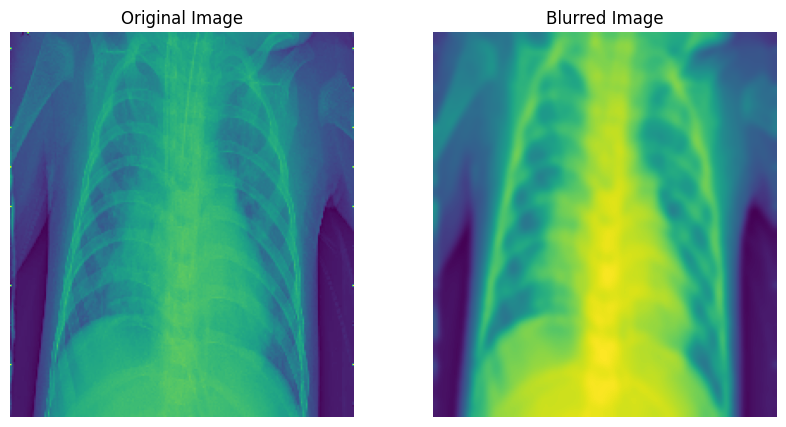

In [208]:
for sample in test_data:
    baseline = torch.tensor(sample[0])
    break
baseline_img = random.choice(baseline)

def create_blurred_baseline(image, blur_radius):
    image_np = np.array(image)
    blurred_image = cv2.GaussianBlur(image_np, (blur_radius, blur_radius), 0)
    return blurred_image
blur_radius = 11
blurred_baseline = create_blurred_baseline(baseline_img, blur_radius)

# original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(baseline_img)
plt.title('Original Image')
plt.axis('off')
# blurred image
plt.subplot(1, 2, 2)
plt.imshow(blurred_baseline)
plt.title('Blurred Image')
plt.axis('off')
plt.show()

# to tensor
baseline_img_tensor = torch.tensor(blurred_baseline, dtype=torch.float32)
# alternatively: baseline_img_tensor = torch.tensor([0.0])

In [209]:
negatives = []
positives = []
while len(negatives) < 5 or len(positives) < 5:
    attribution_data = []
    for sample in test_data:
        attribution_data = sample
        break
    for i in range(len(attribution_data[1])):
        if attribution_data[1][i] == 0:
            negatives.append(attribution_data[0][i])
        if attribution_data[1][i] == 1:
            positives.append(attribution_data[0][i])
            


In [210]:
ig = IntegratedGradients(model)
attributions = ig.attribute(torch.empty(224,200))

Exception ignored in: <function BaseCAM.__del__ at 0xfffe36db5b20>
Traceback (most recent call last):
  File "/home/ilboglions/anaconda3/envs/JupyterEnv/lib/python3.12/site-packages/pytorch_grad_cam/base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'
Exception ignored in: <function BaseCAM.__del__ at 0xfffe36db5b20>
Traceback (most recent call last):
  File "/home/ilboglions/anaconda3/envs/JupyterEnv/lib/python3.12/site-packages/pytorch_grad_cam/base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'
Exception ignored in: <function BaseCAM.__del__ at 0xfffe36db5b20>
Traceback (most recent call last):
  File "/home/ilboglions/anaconda3/envs/JupyterEnv/lib/python3.12/site-packages/pytorch_grad_cam/base_cam.py", line 196, in __del__
    se

ValueError: Input 0 of layer "functional_89" is incompatible with the layer: expected shape=(None, 224, 200, 1), found shape=torch.Size([11200, 200])

In [ ]:
# 1 - attribution maps
def visualize_attributions(images, title):
    for img in images:
        attributions = ig.attribute(img, baseline_img_tensor)
        # image
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original Image')

        #attribution map
        plt.subplot(1, 2, 2)
        plt.imshow(attributions.squeeze().cpu().detach().numpy(), cmap='viridis', alpha=0.8)
        plt.title('Attribution Map')

        plt.suptitle(title)
        plt.show()

# Visualize attribution maps for healthy and pneunoma images
visualize_attributions(torch.tensor(negatives), title='Healthy')
visualize_attributions(torch.tensor(positives), title='Pneunoma')

AssertionError: Baseline can be provided as a tensor for just one input and broadcasted to the batch or input and baseline must have the same shape or the baseline corresponding to each input tensor must be a scalar. Found baseline: tensor([[7.5320e-02, 7.8307e-02, 8.6513e-02,  ..., 2.5054e-03, 1.0447e-03,
         6.0999e-04],
        [7.4916e-02, 7.7923e-02, 8.6200e-02,  ..., 2.4291e-03, 1.0039e-03,
         5.8203e-04],
        [7.3836e-02, 7.6897e-02, 8.5353e-02,  ..., 2.2183e-03, 8.9263e-04,
         5.0592e-04],
        ...,
        [4.5104e-03, 6.6910e-03, 1.3516e-02,  ..., 2.2688e-04, 3.0893e-04,
         3.4223e-04],
        [4.2227e-03, 6.4207e-03, 1.3272e-02,  ..., 3.8721e-05, 5.3139e-05,
         5.9031e-05],
        [4.2030e-03, 6.3999e-03, 1.3243e-02,  ..., 2.5142e-05, 3.4503e-05,
         3.8329e-05]]) and input: tensor([[[0.2627],
         [0.2667],
         [0.2627],
         ...,
         [0.0745],
         [0.0824],
         [0.0196]],

        [[0.2588],
         [0.2745],
         [0.2275],
         ...,
         [0.0863],
         [0.0588],
         [0.0235]],

        [[0.2863],
         [0.2745],
         [0.2353],
         ...,
         [0.0824],
         [0.0510],
         [0.1059]],

        ...,

        [[0.0000],
         [0.0000],
         [0.0000],
         ...,
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         ...,
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         ...,
         [0.0000],
         [0.0000],
         [0.0000]]])

## 4 - Q4 GRAD-CAM

In [206]:
model.layers

[<InputLayer name=input_layer_5, built=True>,
 <Conv2D name=conv2d_35, built=True>,
 <MaxPooling2D name=max_pooling2d_20, built=True>,
 <Conv2D name=conv2d_36, built=True>,
 <MaxPooling2D name=max_pooling2d_21, built=True>,
 <Conv2D name=conv2d_37, built=True>,
 <MaxPooling2D name=max_pooling2d_22, built=True>,
 <Conv2D name=conv2d_38, built=True>,
 <MaxPooling2D name=max_pooling2d_23, built=True>,
 <Flatten name=flatten_5, built=True>,
 <Dense name=dense_13, built=True>,
 <Dense name=dense_14, built=True>]

In [207]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

targets = [ClassifierOutputTarget(1)]
target_layers = ["conv2d_38"]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)


AttributeError: 'Functional' object has no attribute 'eval'

## 5 - Q5 DATA RANDOMIZATION TEST

In [ ]:
#TODO
# random permutation of labels
permuted_train_df = train_df.copy()
permuted_train_df['label'] = np.random.permutation(permuted_train_df['label'])

# train again model


# compute attributions for the permuted model on the test set

# compare atrtibutions of original and permuted models
mean_abs_diff = torch.mean(torch.abs(original_attributions - permuted_attributions))
print(f'Mean Absolute Difference: {mean_abs_diff:.4f}')